<a href="https://colab.research.google.com/github/jarekwan/jarwan_projekt/blob/main/Projekt2A_brudnopis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#TESTOWANIE PROBA DZIALANIA nowego zrodla danych
# brudnopis

import pandas as pd
import requests

# --- Lista wskaźników do pobrania ---
indicators = {
    "gdp_per_capita": "NY.GDP.PCAP.CD",
    "inflation": "FP.CPI.TOTL.ZG",
    "unemployment": "SL.UEM.TOTL.ZS",
    "life_expectancy": "SP.DYN.LE00.IN",
    "population": "SP.POP.TOTL"
}

# --- Pobieranie danych ---
dfs = []
for name, code in indicators.items():
    url = f"http://api.worldbank.org/v2/country/PL/indicator/{code}?format=json&per_page=100"
    response = requests.get(url)
    data = response.json()
    records = data[1]
    df_temp = pd.json_normalize(records)[["date", "value"]]
    df_temp = df_temp.rename(columns={"value": name})
    dfs.append(df_temp)

# --- Łączenie po roku (date) ---
df = dfs[0]
for d in dfs[1:]:
    df = pd.merge(df, d, on="date", how="outer")

# --- Konwersja roku na int i sortowanie ---
df["date"] = df["date"].astype(int)
df = df.sort_values("date").reset_index(drop=True)

# Podgląd danych
print(df.head(150))


    date  gdp_per_capita  inflation  unemployment  life_expectancy  population
0   1960             NaN        NaN           NaN        67.680488    29637450
1   1961             NaN        NaN           NaN        67.778049    29964000
2   1962             NaN        NaN           NaN        67.426829    30308500
3   1963             NaN        NaN           NaN        68.375610    30712000
4   1964             NaN        NaN           NaN        68.629268    31139450
..   ...             ...        ...           ...              ...         ...
60  2020    16150.929101   3.374470         3.155        76.400000    37515748
61  2021    18635.508881   5.055027         3.268        75.351220    36981559
62  2022    18891.213529  14.429451         2.811        77.156098    36821749
63  2023    22145.264309  11.528913         2.743        78.507317    36687353
64  2024    25022.671645   3.790609         2.472              NaN    36554707

[65 rows x 6 columns]


 1. Pobranie i przygotowanie danych

In [3]:

# TESTOWANIE / BRUDOPIS SPRAWDZAM NOWE DANE
import requests
import json

# Kilka wskaźników z World Bank dla Polski
urls = {
    "gdp_per_capita": "http://api.worldbank.org/v2/country/PL/indicator/NY.GDP.PCAP.CD?format=json&per_page=100",
    "inflation": "http://api.worldbank.org/v2/country/PL/indicator/FP.CPI.TOTL.ZG?format=json&per_page=100",
    "unemployment": "http://api.worldbank.org/v2/country/PL/indicator/SL.UEM.TOTL.ZS?format=json&per_page=100",
    "population": "http://api.worldbank.org/v2/country/PL/indicator/SP.POP.TOTL?format=json&per_page=100",
    "life_expectancy": "http://api.worldbank.org/v2/country/PL/indicator/SP.DYN.LE00.IN?format=json&per_page=100"
}

# Pobranie i wyświetlenie pełnego JSON dla każdego wskaźnika
for name, url in urls.items():
    print(f"\n===== {name.upper()} =====")
    response = requests.get(url)
    data = response.json()
    print(json.dumps(data, indent=4, ensure_ascii=False))





Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
                "id": "NY.GDP.PCAP.CD",
                "value": "GDP per capita (current US$)"
            },
            "country": {
                "id": "PL",
                "value": "Poland"
            },
            "countryiso3code": "POL",
            "date": "2008",
            "value": 14048.5604672654,
            "unit": "",
            "obs_status": "",
            "decimal": 1
        },
        {
            "indicator": {
                "id": "NY.GDP.PCAP.CD",
                "value": "GDP per capita (current US$)"
            },
            "country": {
                "id": "PL",
                "value": "Poland"
            },
            "countryiso3code": "POL",
            "date": "2007",
            "value": 11272.5293683383,
            "unit": "",
            "obs_status": "",
            "decimal": 1
        },
        {
            "indicator": {
                "id": "NY.GDP.PCAP.CD",
     

In [ ]:

# #PODGLAD DANYCH ABY ZOBACZYC CO JEST W SRODKU
# #TESTOWANIE STARE ZRODLO DANYCH

# import requests
# import json

# # Adres API
# url = "https://api.nbp.pl/api/exchangerates/tables/A?format=json"
# response = requests.get(url)
# data = response.json()

# # Ładne formatowanie JSON (żeby było czytelnie)
# print(json.dumps(data, indent=4, ensure_ascii=False))
# # widac tutaj klucze glowne: table, no, effectiveDate, rates
# #pod kluczem rates sa klucze:currency, code, mid gdzi ewidac potem string i string i float

In [ ]:
# TESTOWANIE STARE ZRODLO DANYCH import requests
# import json

# # Adres API (PKB per capita dla Polski w formacie JSON)
# url = "http://api.worldbank.org/v2/country/POL/indicator/NY.GDP.PCAP.CD?format=json&per_page=100"

# response = requests.get(url)
# data = response.json()

# # Ładne formatowanie JSON (żeby było czytelnie)
# print(json.dumps(data, indent=4, ensure_ascii=False))

# # 👇 Wyjaśnienie:
# # data[1] zawiera listę rekordów z kluczami: country, date, value, indicator itd.


In [4]:
#TESTOWAIE
#CHCE ZOBACZYC CO JEST W POZCZEGOLNYCH WYWOLANIACH

import requests
import json

# Kilka wskaźników z World Bank dla Polski
urls = {
    "gdp_per_capita": "http://api.worldbank.org/v2/country/PL/indicator/NY.GDP.PCAP.CD?format=json&per_page=100",
    "inflation": "http://api.worldbank.org/v2/country/PL/indicator/FP.CPI.TOTL.ZG?format=json&per_page=100",
    "unemployment": "http://api.worldbank.org/v2/country/PL/indicator/SL.UEM.TOTL.ZS?format=json&per_page=100",
    "population": "http://api.worldbank.org/v2/country/PL/indicator/SP.POP.TOTL?format=json&per_page=100",
    "life_expectancy": "http://api.worldbank.org/v2/country/PL/indicator/SP.DYN.LE00.IN?format=json&per_page=100"
}

# Podgląd struktury danych dla każdego wskaźnika
for name, url in urls.items():
    print(f"\n===== {name.upper()} =====")
    response = requests.get(url)
    data = response.json()

    print("Całość:", type(data), len(data))
    print("Metadane:", data[0])
    print("Pierwszy rekord:", data[1][0])
    print("Klucze rekordu:", data[1][0].keys())





===== GDP_PER_CAPITA =====
Całość: <class 'list'> 2
Metadane: {'page': 1, 'pages': 1, 'per_page': 100, 'total': 65, 'sourceid': '2', 'lastupdated': '2025-07-01'}
Pierwszy rekord: {'indicator': {'id': 'NY.GDP.PCAP.CD', 'value': 'GDP per capita (current US$)'}, 'country': {'id': 'PL', 'value': 'Poland'}, 'countryiso3code': 'POL', 'date': '2024', 'value': 25022.6716445953, 'unit': '', 'obs_status': '', 'decimal': 1}
Klucze rekordu: dict_keys(['indicator', 'country', 'countryiso3code', 'date', 'value', 'unit', 'obs_status', 'decimal'])

===== INFLATION =====
Całość: <class 'list'> 2
Metadane: {'page': 1, 'pages': 1, 'per_page': 100, 'total': 65, 'sourceid': '2', 'lastupdated': '2025-07-01'}
Pierwszy rekord: {'indicator': {'id': 'FP.CPI.TOTL.ZG', 'value': 'Inflation, consumer prices (annual %)'}, 'country': {'id': 'PL', 'value': 'Poland'}, 'countryiso3code': 'POL', 'date': '2024', 'value': 3.79060897630203, 'unit': '', 'obs_status': '', 'decimal': 1}
Klucze rekordu: dict_keys(['indicator',

🔹 Etapy projektu
1. Pobranie i przygotowanie danych
•	Pobranie danych z API (np. NBP, Eurostat)
•	Serializacja → zapis do JSON/CSV.
•	Walidacja struktur (Pydantic + regex dla kolumn typu daty/kody walut).
•	Wstępne czyszczenie braków i wartości odstających.


In [5]:
# poprawiana wersja
# WŁAŚCIWY KOD
# POBRANIE DANYCH I SERIALIZACJA

import pandas as pd
import requests

# --- Wskaźniki z World Bank dla Polski ---
urls = {
    "gdp_per_capita": "http://api.worldbank.org/v2/country/PL/indicator/NY.GDP.PCAP.CD?format=json&per_page=100",
    "inflation": "http://api.worldbank.org/v2/country/PL/indicator/FP.CPI.TOTL.ZG?format=json&per_page=100",
    "unemployment": "http://api.worldbank.org/v2/country/PL/indicator/SL.UEM.TOTL.ZS?format=json&per_page=100",
    "population": "http://api.worldbank.org/v2/country/PL/indicator/SP.POP.TOTL?format=json&per_page=100",
    "life_expectancy": "http://api.worldbank.org/v2/country/PL/indicator/SP.DYN.LE00.IN?format=json&per_page=100"
}

# --- Pobieranie i łączenie danych ---
dfs = []

for name, url in urls.items():
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Błąd pobierania danych dla {name} (status {response.status_code})")

    data = response.json()
    records = data[1]  # właściwe dane

    df_tmp = pd.json_normalize(records)[["country.value", "date", "value"]]
    df_tmp.rename(columns={"value": name}, inplace=True)  # nazwa wskaźnika jako kolumna
    dfs.append(df_tmp)

# --- Scalanie danych po dacie ---
df = dfs[0]
for df_tmp in dfs[1:]:
    df = df.merge(df_tmp, on=["country.value", "date"], how="outer")

# Sortowanie po dacie malejąco
df["date"] = df["date"].astype(int)
df = df.sort_values("date", ascending=False)

# --- Podgląd danych ---
print("Podgląd danych z World Bank (Polska):")
print(df.head())

# --- Serializacja ---
df.to_csv("worldbank_indicators.csv", index=False)
df.to_json("worldbank_indicators.json", orient="records", force_ascii=False, indent=2)

print("✅ Dane zapisane do plików: worldbank_indicators.csv i worldbank_indicators.json")





Podgląd danych z World Bank (Polska):
   country.value  date  gdp_per_capita  inflation  unemployment  population  \
64        Poland  2024    25022.671645   3.790609         2.472    36554707   
63        Poland  2023    22145.264309  11.528913         2.743    36687353   
62        Poland  2022    18891.213529  14.429451         2.811    36821749   
61        Poland  2021    18635.508881   5.055027         3.268    36981559   
60        Poland  2020    16150.929101   3.374470         3.155    37515748   

    life_expectancy  
64              NaN  
63        78.507317  
62        77.156098  
61        75.351220  
60        76.400000  
✅ Dane zapisane do plików: worldbank_indicators.csv i worldbank_indicators.json


Walidacja + Czyszczenie

In [6]:
from pydantic import BaseModel, ValidationError
from typing import Optional
import pandas as pd

# --- Model danych z World Bank (dla wielu wskaźników) ---
class IndicatorData(BaseModel):
    country: str
    date: int
    gdp_per_capita: Optional[float]
    inflation: Optional[float]
    unemployment: Optional[float]
    population: Optional[float]
    life_expectancy: Optional[float]

# --- Walidacja danych ---
try:
    for _, row in df.iterrows():
        IndicatorData(
            country=row["country.value"],
            date=int(row["date"]),
            gdp_per_capita=row.get("gdp_per_capita"),
            inflation=row.get("inflation"),
            unemployment=row.get("unemployment"),
            population=row.get("population"),
            life_expectancy=row.get("life_expectancy")
        )
    print("✅ Wszystkie wiersze poprawne")
except ValidationError as e:
    print("❌ Błąd walidacji:", e)

# --- Sprawdzenie braków danych ---
print("\n🔎 Braki danych:")
print(df.isna().sum())

# --- Statystyki opisowe dla wszystkich kolumn numerycznych ---
print("\n📊 Statystyki opisowe:")
print(df.describe())

# --- Wykrycie wartości odstających ---
print("\n🚨 Wartości odstające:")
for col in ["gdp_per_capita", "inflation", "unemployment", "population", "life_expectancy"]:
    if col in df.columns:
        outliers = df[(df[col] < 0) | (df[col] > df[col].mean() + 5*df[col].std())]
        print(f"\n{col}: liczba podejrzanych wartości = {len(outliers)}")
        if not outliers.empty:
            print(outliers[["country.value", "date", col]])





✅ Wszystkie wiersze poprawne

🔎 Braki danych:
country.value       0
date                0
gdp_per_capita     30
inflation          11
unemployment       31
population          0
life_expectancy     1
dtype: int64

📊 Statystyki opisowe:
             date  gdp_per_capita   inflation  unemployment    population  \
count    65.00000       35.000000   54.000000     34.000000  6.500000e+01   
mean   1992.00000    10078.014122   27.772551     10.381088  3.617264e+07   
std      18.90767     6219.942375   83.572495      5.327135  2.688893e+06   
min    1960.00000     1731.209509   -0.874126      2.472000  2.963745e+07   
25%    1976.00000     4468.070840    2.306924      6.373000  3.435630e+07   
50%    1992.00000    11272.529368    5.231681      9.983000  3.766804e+07   
75%    2008.00000    13980.950993   16.262726     13.769250  3.814127e+07   
max    2024.00000    25022.671645  567.878801     20.211000  3.866348e+07   

       life_expectancy  
count        64.000000  
mean         72.6460

KONTYNUACJA :Symulacje i rozkłady (NumPy + Matplotlib)
•	generowanie próbek z rozkładu normalnego, jednorodnego, wykładniczego,
•	wizualizacja histogramów + porównanie z teoretyczną krzywą gęstości,
•	demonstracja CLT.


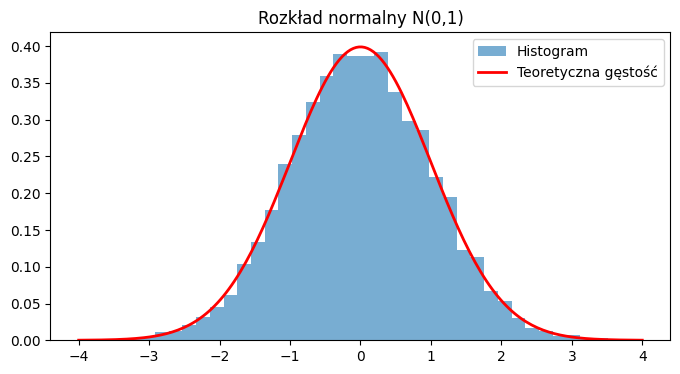

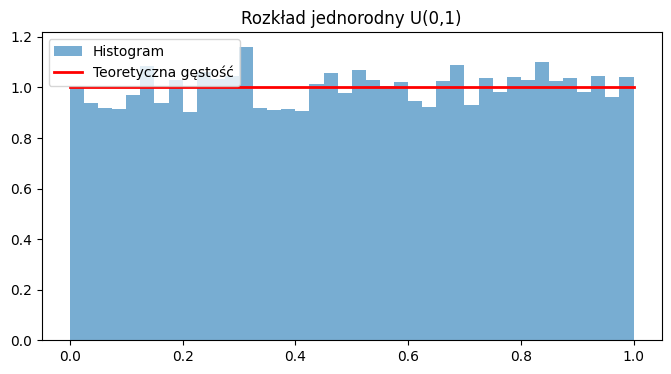

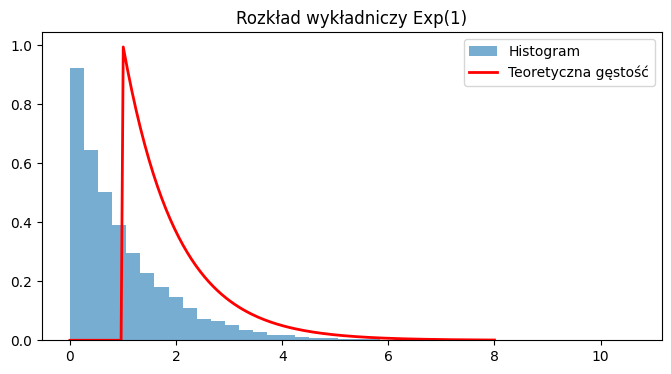

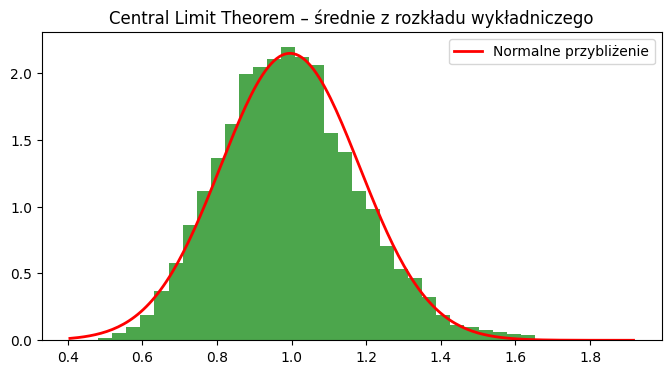

In [7]:
# --- Symulacje i rozkłady ---
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform, expon

# Ustalmy rozmiar próbki
N = 10000

# 1. Rozkład normalny
normal_data = np.random.normal(loc=0, scale=1, size=N)

plt.figure(figsize=(8,4))
plt.hist(normal_data, bins=40, density=True, alpha=0.6, label="Histogram")
x = np.linspace(-4, 4, 200)
plt.plot(x, norm.pdf(x, 0, 1), 'r-', lw=2, label="Teoretyczna gęstość")
plt.title("Rozkład normalny N(0,1)")
plt.legend()
plt.show()


# 2. Rozkład jednorodny
uniform_data = np.random.uniform(low=0, high=1, size=N)

plt.figure(figsize=(8,4))
plt.hist(uniform_data, bins=40, density=True, alpha=0.6, label="Histogram")
x = np.linspace(0, 1, 200)
plt.plot(x, uniform.pdf(x, 0, 1), 'r-', lw=2, label="Teoretyczna gęstość")
plt.title("Rozkład jednorodny U(0,1)")
plt.legend()
plt.show()


# 3. Rozkład wykładniczy
expon_data = np.random.exponential(scale=1, size=N)

plt.figure(figsize=(8,4))
plt.hist(expon_data, bins=40, density=True, alpha=0.6, label="Histogram")
x = np.linspace(0, 8, 200)
plt.plot(x, expon.pdf(x, 1), 'r-', lw=2, label="Teoretyczna gęstość")
plt.title("Rozkład wykładniczy Exp(1)")
plt.legend()
plt.show()


# 4. Demonstracja Central Limit Theorem (CLT)
sample_means = []
for _ in range(5000):              # liczba powtórzeń
    sample = np.random.exponential(scale=1, size=30)  # próbka losowa (np. z wykładniczego)
    sample_means.append(np.mean(sample))

plt.figure(figsize=(8,4))
plt.hist(sample_means, bins=40, density=True, alpha=0.7, color='g')
x = np.linspace(min(sample_means), max(sample_means), 200)
plt.plot(x, norm.pdf(x, np.mean(sample_means), np.std(sample_means)), 'r-', lw=2, label="Normalne przybliżenie")
plt.title("Central Limit Theorem – średnie z rozkładu wykładniczego")
plt.legend()
plt.show()


SPRAWDZAM JAKIE KOLUMNY SA W DF

In [8]:
print(df.head())
print(df.columns)


   country.value  date  gdp_per_capita  inflation  unemployment  population  \
64        Poland  2024    25022.671645   3.790609         2.472    36554707   
63        Poland  2023    22145.264309  11.528913         2.743    36687353   
62        Poland  2022    18891.213529  14.429451         2.811    36821749   
61        Poland  2021    18635.508881   5.055027         3.268    36981559   
60        Poland  2020    16150.929101   3.374470         3.155    37515748   

    life_expectancy  
64              NaN  
63        78.507317  
62        77.156098  
61        75.351220  
60        76.400000  
Index(['country.value', 'date', 'gdp_per_capita', 'inflation', 'unemployment',
       'population', 'life_expectancy'],
      dtype='object')


Eksploracyjna analiza danych (EDA)
•	Pandas: opis statystyczny (describe(), mediany, odchylenia).
•	NumPy: logarytmy, normalizacja, standaryzacja.
•	Wizualizacje Matplotlib/Seaborn: histogramy, scatterploty, heatmapy korelacji.
•	Wykrywanie outlierów (boxploty, IQR, Z-score).


📊 Opis statystyczny Pandas:
       gdp_per_capita   inflation  unemployment    population  life_expectancy
count       35.000000   54.000000     34.000000  6.500000e+01        64.000000
mean     10078.014122   27.772551     10.381088  3.617264e+07        72.646037
std       6219.942375   83.572495      5.327135  2.688893e+06         3.070277
min       1731.209509   -0.874126      2.472000  2.963745e+07        67.426829
25%       4468.070840    2.306924      6.373000  3.435630e+07        70.557927
50%      11272.529368    5.231681      9.983000  3.766804e+07        71.224390
75%      13980.950993   16.262726     13.769250  3.814127e+07        75.270732
max      25022.671645  567.878801     20.211000  3.866348e+07        78.507317

🔸 Mediany:
gdp_per_capita     1.127253e+04
inflation          5.231681e+00
unemployment       9.983000e+00
population         3.766804e+07
life_expectancy    7.122439e+01
dtype: float64

🔸 Odchylenia standardowe:
gdp_per_capita     6.219942e+03
inflation      

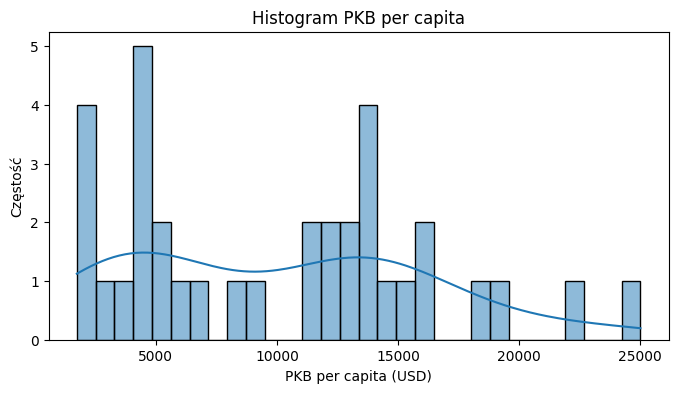

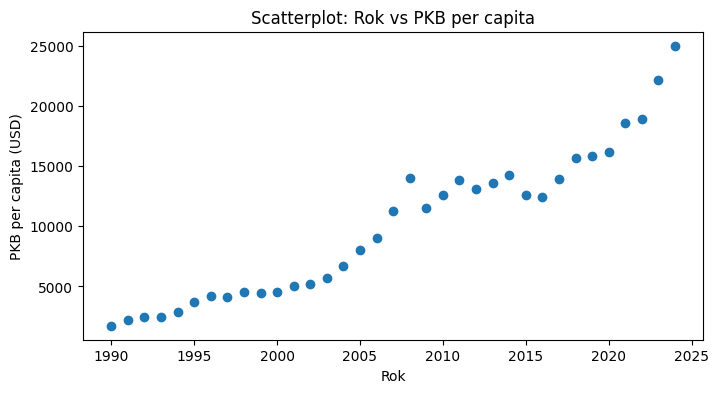

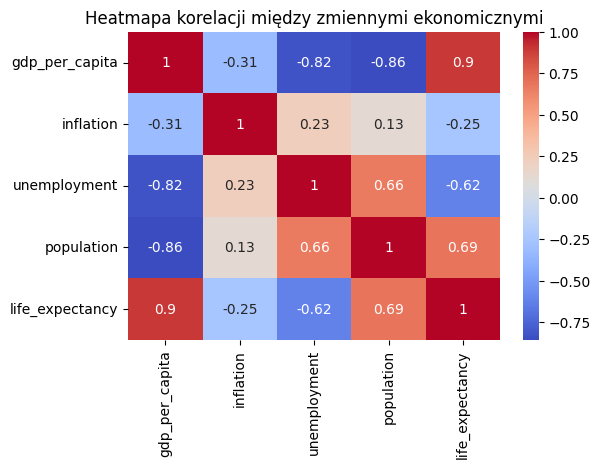

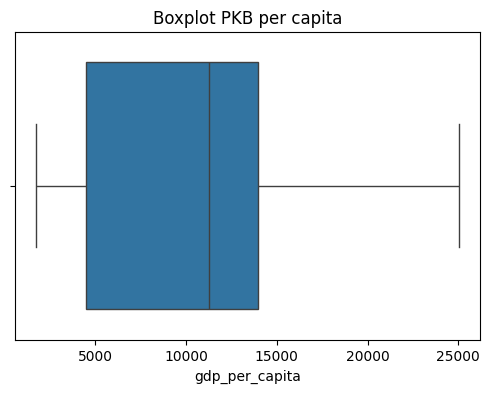

🔎 Liczba outlierów (IQR): 0
🔎 Liczba outlierów (Z-score > 3): 0


In [9]:
# --- Eksploracyjna Analiza Danych (EDA) ---
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Opis statystyczny Pandas
print("📊 Opis statystyczny Pandas:")
print(df[["gdp_per_capita", "inflation", "unemployment", "population", "life_expectancy"]].describe())

print("\n🔸 Mediany:")
print(df[["gdp_per_capita", "inflation", "unemployment", "population", "life_expectancy"]].median())

print("\n🔸 Odchylenia standardowe:")
print(df[["gdp_per_capita", "inflation", "unemployment", "population", "life_expectancy"]].std())

# 2. NumPy: logarytmy, normalizacja, standaryzacja dla PKB
values = df["gdp_per_capita"].dropna().values

log_values = np.log(values)
normalized_values = (values - values.min()) / (values.max() - values.min())
standardized_values = (values - values.mean()) / values.std()

# 3. Wizualizacje

# Histogram PKB
plt.figure(figsize=(8, 4))
sns.histplot(df["gdp_per_capita"].dropna(), bins=30, kde=True)
plt.title("Histogram PKB per capita")
plt.xlabel("PKB per capita (USD)")
plt.ylabel("Częstość")
plt.show()

# Scatterplot: Rok vs PKB
plt.figure(figsize=(8, 4))
plt.scatter(df["date"], df["gdp_per_capita"])
plt.title("Scatterplot: Rok vs PKB per capita")
plt.xlabel("Rok")
plt.ylabel("PKB per capita (USD)")
#plt.xticks(rotation=45)
plt.show()

# Heatmapa korelacji
numeric_df = df[["gdp_per_capita", "inflation", "unemployment", "population", "life_expectancy"]]
plt.figure(figsize=(6, 4))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Heatmapa korelacji między zmiennymi ekonomicznymi")
plt.show()

# 4. Wykrywanie wartości odstających (outlierów) dla PKB

# Boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["gdp_per_capita"])
plt.title("Boxplot PKB per capita")
plt.show()

# IQR
Q1 = df["gdp_per_capita"].quantile(0.25)
Q3 = df["gdp_per_capita"].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = df[(df["gdp_per_capita"] < Q1 - 1.5 * IQR) | (df["gdp_per_capita"] > Q3 + 1.5 * IQR)]
print(f"🔎 Liczba outlierów (IQR): {len(outliers_iqr)}")

# Z-score
z_scores = (df["gdp_per_capita"] - df["gdp_per_capita"].mean()) / df["gdp_per_capita"].std()
outliers_z = df[np.abs(z_scores) > 3]
print(f"🔎 Liczba outlierów (Z-score > 3): {len(outliers_z)}")



•	NumPy meshgrid + contour plot (żeby ćwiczyć wizualizacje siatek).

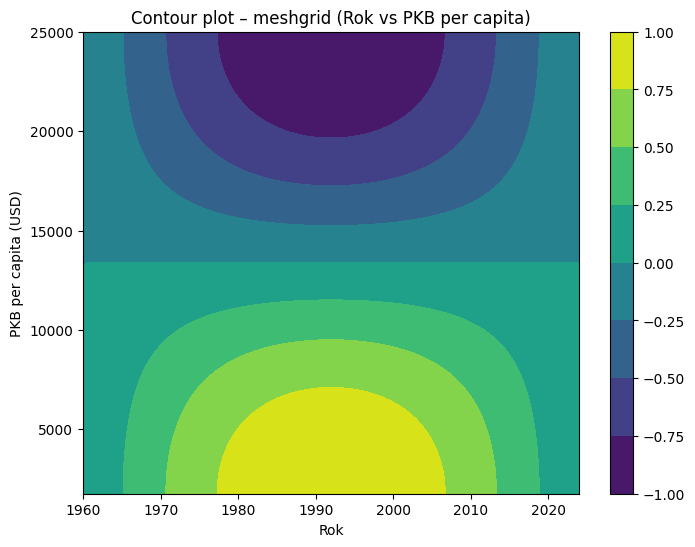

In [10]:
# --- NumPy meshgrid + contour plot (wizualizacja siatek) ---

import numpy as np
import matplotlib.pyplot as plt

# Tworzymy siatkę punktów (x = lata, y = PKB per capita)
x = np.linspace(df["date"].min(), df["date"].max(), 100)
y = np.linspace(df["gdp_per_capita"].min(), df["gdp_per_capita"].max(), 100)
X, Y = np.meshgrid(x, y)

# Prosta funkcja zależności (np. "energia" = kombinacja lat i PKB)
Z = np.sin((X - X.min()) / (X.max() - X.min()) * np.pi) * \
    np.cos((Y - Y.min()) / (Y.max() - Y.min()) * np.pi)

# Rysowanie contour plot
plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, Z, cmap="viridis")
plt.colorbar(cp)
plt.title("Contour plot – meshgrid (Rok vs PKB per capita)")
plt.xlabel("Rok")
plt.ylabel("PKB per capita (USD)")
plt.show()


📊 Opis statystyczny Pandas:
count    33.000000
mean      1.250932
std       1.614192
min       0.000218
25%       0.087300
50%       0.466700
75%       2.182800
max       4.987500
Name: mid, dtype: float64

🔸 Mediana: 0.4667
🔸 Odchylenie standardowe: 1.614191607953539


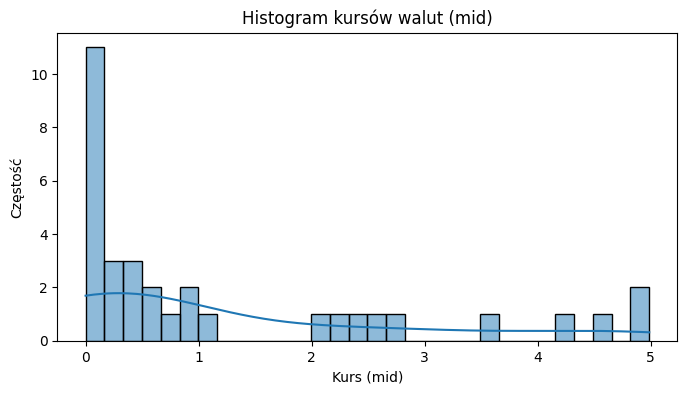

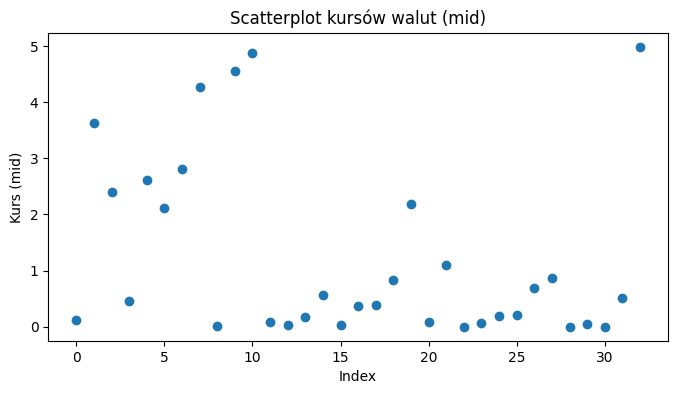

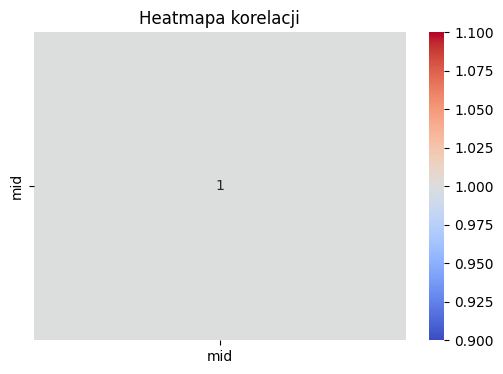

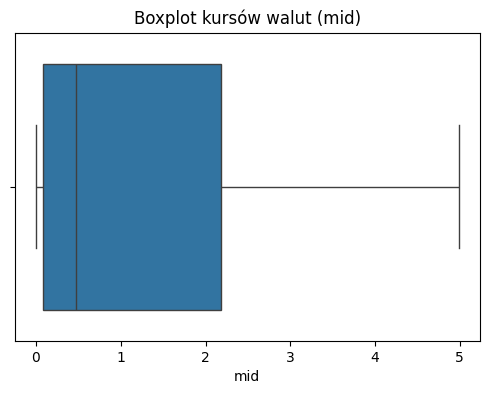

🔎 Liczba outlierów (IQR): 0
🔎 Liczba outlierów (Z-score > 3): 0


In [ ]:


#STARY KOD DOTYCZYL NBP A NIE WORLDBANK

# --- Eksploracyjna Analiza Danych (EDA) ---


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Opis statystyczny Pandas
print("📊 Opis statystyczny Pandas:")
print(df["mid"].describe())
print("\n🔸 Mediana:", df["mid"].median())
print("🔸 Odchylenie standardowe:", df["mid"].std())

# 2. NumPy: logarytmy, normalizacja, standaryzacja
mid_values = df["mid"].values

log_mid = np.log(mid_values)
normalized_mid = (mid_values - mid_values.min()) / (mid_values.max() - mid_values.min())
standardized_mid = (mid_values - mid_values.mean()) / mid_values.std()

# 3. Wizualizacje

# Histogram
plt.figure(figsize=(8, 4))
sns.histplot(df["mid"], bins=30, kde=True)
plt.title("Histogram kursów walut (mid)")
plt.xlabel("Kurs (mid)")
plt.ylabel("Częstość")
plt.show()

# Scatterplot (dla przykładu, jeśli byłaby data – tu losowy indeks)
plt.figure(figsize=(8, 4))
plt.scatter(df.index, df["mid"])
plt.title("Scatterplot kursów walut (mid)")
plt.xlabel("Index")
plt.ylabel("Kurs (mid)")
plt.show()

# Heatmapa korelacji (tylko jeśli więcej zmiennych liczbowych)
if "mid" in df.columns:
    numeric_df = df.select_dtypes(include=[np.number])
    plt.figure(figsize=(6, 4))
    sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
    plt.title("Heatmapa korelacji")
    plt.show()

# 4. Wykrywanie wartości odstających (outlierów)

# Boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["mid"])
plt.title("Boxplot kursów walut (mid)")
plt.show()

# IQR
Q1 = df["mid"].quantile(0.25)
Q3 = df["mid"].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = df[(df["mid"] < Q1 - 1.5 * IQR) | (df["mid"] > Q3 + 1.5 * IQR)]
print(f"🔎 Liczba outlierów (IQR): {len(outliers_iqr)}")

# Z-score
z_scores = (df["mid"] - df["mid"].mean()) / df["mid"].std()
outliers_z = df[np.abs(z_scores) > 3]
print(f"🔎 Liczba outlierów (Z-score > 3): {len(outliers_z)}")


PONIZEJ NA BRUDNO ROBOCZA WERSJA

In [ ]:

import pandas as pd
import numpy as np
import requests
import re
from pydantic import BaseModel, ValidationError

# Przykład pobrania danych (API NBP kursy walut)
url = "https://api.nbp.pl/api/exchangerates/tables/A?format=json"
data = requests.get(url).json()
df = pd.json_normalize(data[0]['rates'])
print(df.head())

# Walidacja kolumny waluty
class Currency(BaseModel):
    code: str

try:
    for c in df['code']:
        Currency(code=c)
except ValidationError as e:
    print(e)

# Prosta serializacja
df.to_csv("data.csv", index=False)


             currency code     mid
0     bat (Tajlandia)  THB  0.1130
1   dolar amerykański  USD  3.6295
2  dolar australijski  AUD  2.3949
3     dolar Hongkongu  HKD  0.4666
4    dolar kanadyjski  CAD  2.6127


 2. EDA (eksploracja danych)

             mid
count  33.000000
mean    1.249594
std     1.612480
min     0.000217
25%     0.087300
50%     0.466600
75%     2.179100
max     4.970800


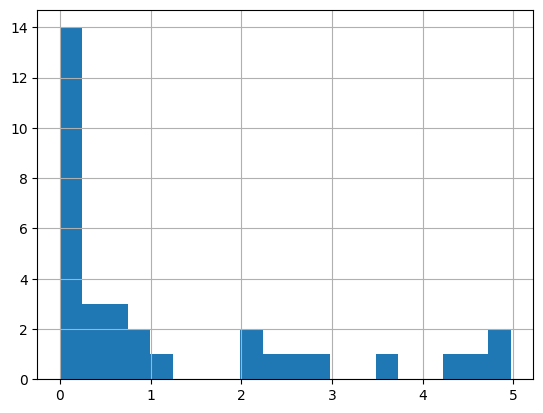

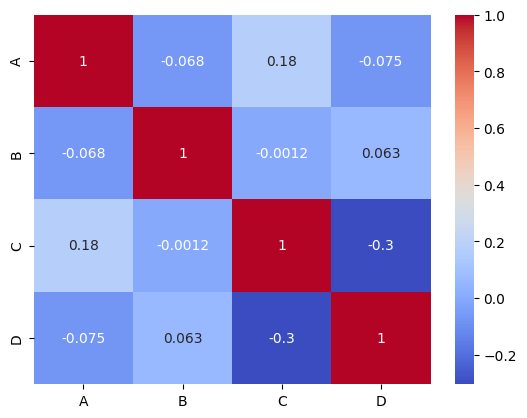

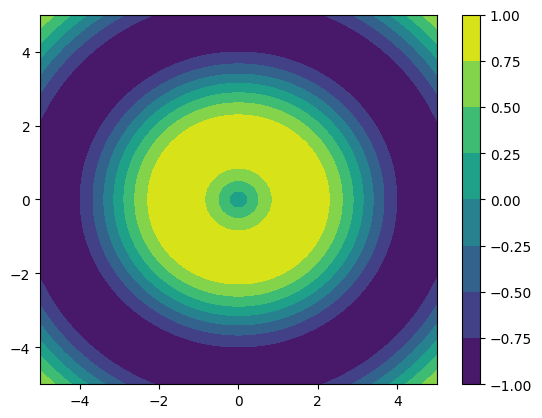

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

print(df.describe())

# Histogram
df['mid'].hist(bins=20)
plt.show()

# Heatmapa korelacji (przykład na sztucznych danych)
df2 = pd.DataFrame(np.random.randn(100, 4), columns=list("ABCD"))
sns.heatmap(df2.corr(), annot=True, cmap="coolwarm")
plt.show()

# Meshgrid + contour plot
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

plt.contourf(X, Y, Z, cmap="viridis")
plt.colorbar()
plt.show()


3. Statystyka klasyczna

95% CI: (np.float64(98.69413389083786), np.float64(103.90888880610567))
Shapiro-Wilk: ShapiroResult(statistic=np.float64(0.9774151949589392), pvalue=np.float64(0.4488425719013703))
T-test: TtestResult(statistic=np.float64(0.9783452568427398), pvalue=np.float64(0.3327093449779359), df=np.int64(49))


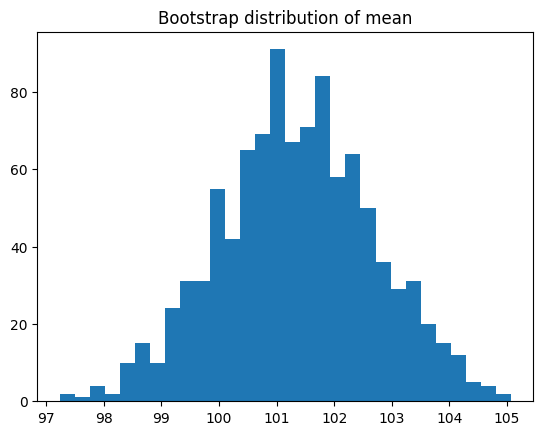

In [ ]:

from scipy import stats

# Przedział ufności dla średniej
sample = np.random.normal(loc=100, scale=10, size=50)
conf_int = stats.norm.interval(0.95, loc=np.mean(sample), scale=stats.sem(sample))
print("95% CI:", conf_int)

# Test normalności
print("Shapiro-Wilk:", stats.shapiro(sample))

# Test t
print("T-test:", stats.ttest_1samp(sample, 100))

# Bootstrap
boot_means = []
for _ in range(1000):
    boot_sample = np.random.choice(sample, size=len(sample), replace=True)
    boot_means.append(np.mean(boot_sample))
plt.hist(boot_means, bins=30)
plt.title("Bootstrap distribution of mean")
plt.show()


4. Regresja liniowa

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     990.8
Date:                Thu, 25 Sep 2025   Prob (F-statistic):           1.05e-33
Time:                        15:57:34   Log-Likelihood:                -103.75
No. Observations:                  50   AIC:                             211.5
Df Residuals:                      48   BIC:                             215.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7493      0.548     12.315      0.0

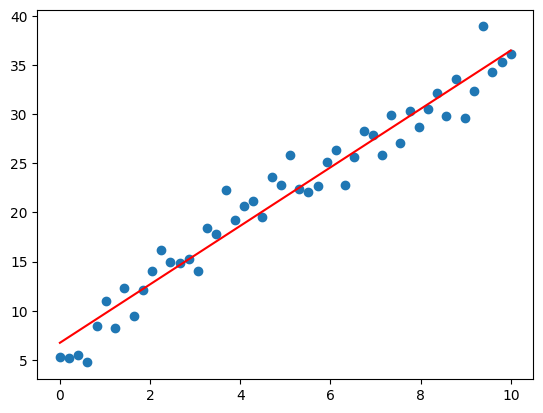

In [ ]:
# =======================================
# 4. Regresja liniowa
# =======================================
import statsmodels.api as sm

X = np.linspace(0, 10, 50)
Y = 3*X + 7 + np.random.normal(0, 2, 50)

X_ = sm.add_constant(X)
model = sm.OLS(Y, X_).fit()
print(model.summary())

plt.scatter(X, Y)
plt.plot(X, model.predict(X_), color="red")
plt.show()


5. Regularyzacja (Ridge, Lasso)

In [ ]:

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

X = df2.drop("A", axis=1)
y = df2["A"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

ridge = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
lasso = make_pipeline(StandardScaler(), Lasso(alpha=0.1))

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

print("Ridge R2:", ridge.score(X_test, y_test))
print("Lasso R2:", lasso.score(X_test, y_test))


Ridge R2: -0.1662488415345651
Lasso R2: -0.10731336350517173


6. Szeregi czasowe

/tmp/ipython-input-3685064161.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range("2020-01-01", periods=100, freq="M")


ADF test: (np.float64(0.6266193983771053), np.float64(0.9882537006790334), 11, 88, {'1%': np.float64(-3.506944401824286), '5%': np.float64(-2.894989819214876), '10%': np.float64(-2.584614550619835)}, np.float64(568.1195638563936))
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -322.395
Date:                Thu, 25 Sep 2025   AIC                            650.791
Time:                        15:58:17   BIC                            658.576
Sample:                    01-31-2020   HQIC                           653.941
                         - 04-30-2028                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

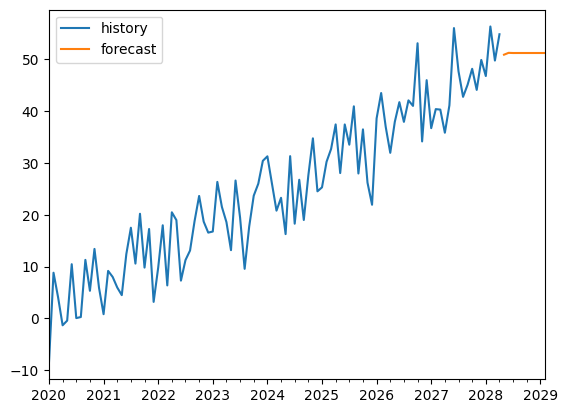

In [ ]:

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Dane sztuczne: trend + szum
dates = pd.date_range("2020-01-01", periods=100, freq="M")
ts = pd.Series(0.5*np.arange(100) + np.random.normal(0, 5, 100), index=dates)

# Test stacjonarności
print("ADF test:", adfuller(ts))

# ARIMA model
model = ARIMA(ts, order=(1,1,1)).fit()
print(model.summary())

forecast = model.forecast(10)
ts.plot(label="history")
forecast.plot(label="forecast")
plt.legend()
plt.show()


7. Prezentacja wyników

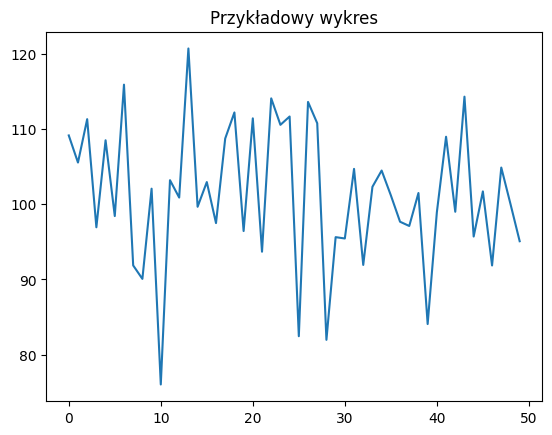

In [ ]:

# Zapis do pliku
df.describe().to_csv("report.csv")

# Przykładowy wykres PNG
plt.plot(sample)
plt.title("Przykładowy wykres")
plt.savefig("report.png")
